In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import sympy as smp

## Propeller data

In [88]:
D = 11 * 25.4 / 1000 # diameter in meters
rho = 1.22 # air density
Va = 17 # horizontal flight velocity
D3 = np.loadtxt('3000RPM.txt', dtype=float, skiprows=1)
J3 = D3[:, 0]
ct3 = D3[:, 1]
cq3 = D3[:, 2] / (2*np.pi)
eta3 = D3[:, 3]

D4 = np.loadtxt('4000RPM.txt', dtype=float, skiprows=1)
J4 = D4[:, 0]
ct4 = D4[:, 1]
cq4 = D4[:, 2] / (2*np.pi)
eta4 = D4[:, 3]

D5 = np.loadtxt('5000RPM.txt', dtype=float, skiprows=1)
J5 = D5[:, 0]
ct5 = D5[:, 1]
cq5 = D5[:, 2] / (2*np.pi)
eta5 = D5[:, 3]

D6 = np.loadtxt('6000RPM.txt', dtype=float, skiprows=1)
J6 = D6[:, 0]
ct6 = D6[:, 1]
cq6 = D6[:, 2] / (2*np.pi)
eta6 = D6[:, 3]

Ct = np.concatenate((ct3, ct4), axis=0)
Ct = np.concatenate((Ct, ct5), axis=0)
Ct = np.concatenate((Ct, ct6), axis=0)

Cq = np.concatenate((cq3, cq4), axis=0)
Cq = np.concatenate((Cq, cq5), axis=0)
Cq = np.concatenate((Cq, cq6), axis=0)

J = np.concatenate((J3, J4), axis=0)
J = np.concatenate((J, J5), axis=0)
J = np.concatenate((J, J6), axis=0)

eta = np.concatenate((eta3, eta4), axis=0)
eta = np.concatenate((eta, eta5), axis=0)
eta = np.concatenate((eta, eta6), axis=0)

## Motor Data

In [89]:
MD = np.loadtxt('C:/Users/PC/Education/SKAT2025/KB-102_SKAT_2025/ПромежуточныйДизайн/СиловаяУстановка/AT2820.txt', dtype= float, skiprows=1)
i0 = float(MD[0, 2])
R = float(MD[0, 1])
kv = MD[0,0] # RPM/volts
kv = float(2*np.pi * kv /60 ) # Volts/(rad/sec)
kq = float(1/kv)
kv = kv**-1
MD, kv

(array([[8.80e+02, 3.90e-02, 1.60e+00, 1.39e-01],
        [1.05e+03, 2.80e-02, 2.00e+00, 1.39e-01]]),
 0.010851473392629226)

## Functions

In [90]:
pcq = np.polyfit(J, Cq, 2)
pcq3 = np.polyfit(J3, cq3, 2)
pcq4 = np.polyfit(J4, cq4, 2)
pcq5 = np.polyfit(J5, cq5, 2)
pcq6 = np.polyfit(J6, cq6, 2)
pct = np.polyfit(J, Ct, 2)
pct3 = np.polyfit(J3, ct3, 2)
pct4 = np.polyfit(J4, ct4, 2)
pct5 = np.polyfit(J5, ct5, 2)
pct6 = np.polyfit(J6, ct6, 2)
peta = np.polyfit(J, eta, 2)

def GetAR(Om, V):
    om = Om * 2 * np.pi / 60
    return 2*np.pi*V/(om * D)

def GetOmega(AR, V): 
    return (2 * np.pi * V / (D * AR)) / (2 * np.pi) * 60

# def GetThrust(Om, V):
#     om = Om * 2 * np.pi / 60
#     return rho * D**4 * om**2 * np.polyval(pct, GetAR(Om, V)) / (4 * np.pi**2)

# def GetTorque(Om, V):
#     om = Om * 2 * np.pi / 60
#     return rho * D**5 * om**2 * np.polyval(pcq, GetAR(Om, V)) / (4 * np.pi**2)

def GetMTorque(Om, Vin):
    om = Om * 2 * np.pi / 60
    return kv*((Vin - kv*om)/R - i0)

def GetTorque(Om, V):
    om = Om * 2 * np.pi / 60
    r = om
    for i in range(np.size(Om)):
        if Om[i] < 3500:
            r[i] = rho * D**5 * om[i]**2 * np.polyval(pcq3, GetAR(Om[i], V)) / (4 * np.pi**2)
        if Om[i] < 4500 and Om[i] >= 3500:
            r[i] = rho * D**5 * om[i]**2 * np.polyval(pcq4, GetAR(Om[i], V)) / (4 * np.pi**2)
        if Om[i] < 5500 and Om[i] >= 4500:
            r[i] = rho * D**5 * om[i]**2 * np.polyval(pcq5, GetAR(Om[i], V)) / (4 * np.pi**2)
        if Om[i] >= 5500:
            r[i] = rho * D**5 * om[i]**2 * np.polyval(pcq6, GetAR(Om[i], V)) / (4 * np.pi**2)
    return r

def GetThrust(Om, V):
    om = Om * 2 * np.pi / 60
    r = om
    for i in range(np.size(Om)):
        if Om[i] < 3500:
            r[i] = rho * D**4 * om[i]**2 * np.polyval(pct3, GetAR(Om[i], V)) / (4 * np.pi**2)
        if Om[i] < 4500 and Om[i] >= 3500:
            r[i] = rho * D**4 * om[i]**2 * np.polyval(pct4, GetAR(Om[i], V)) / (4 * np.pi**2)
        if Om[i] < 5500 and Om[i] >= 4500:
            r[i] = rho * D**4 * om[i]**2 * np.polyval(pct5, GetAR(Om[i], V)) / (4 * np.pi**2)
        if Om[i] >= 5500:
            r[i] = rho * D**4 * om[i]**2 * np.polyval(pct6, GetAR(Om[i], V)) / (4 * np.pi**2)
    return r

def GetMEff(Om, Vin):
    om = Om * 2 * np.pi / 60
    Qm = GetMTorque(Om, Vin)
    return Qm*om * R/ (Vin * (Vin - kv*om))

def GetMPower(Vin, Om):
    om  = Om * 2 * np.pi / 60
    return Vin * (Vin - kv*om)/R

def GetPower(Om, V):
    om = Om * 2 * np.pi / 60
    return GetTorque(Om, V) * om

def GetTotalPower(Om, Vin, V):
    return GetMPower(Vin, Om) + GetPower(Om, V)


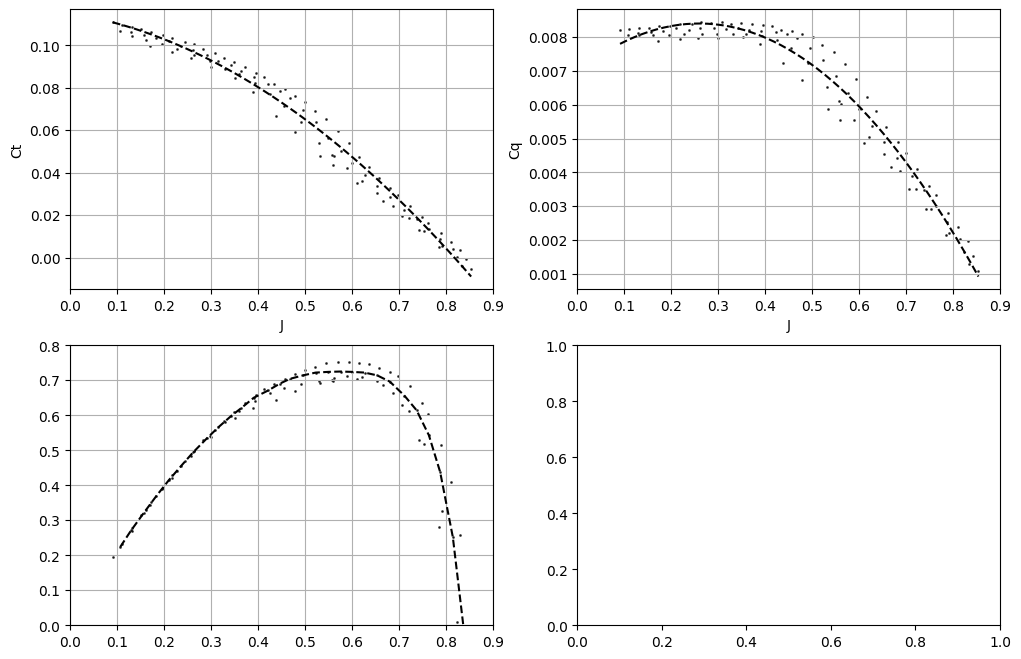

In [91]:
fig1, ax1 = plt.subplots(2,2, figsize=(12, 8))
ax1 = ax1.ravel()
ax1[0].scatter(J, Ct, s=1, c='black', alpha=0.7)
ax1[0].plot(np.linspace(np.min(J), np.max(J)), np.polyval(pct, np.linspace(np.min(J), np.max(J))), '--', c='black')
ax1[0].set_xlabel('J')
ax1[0].set_ylabel('Ct')
ax1[0].grid('Major')
ax1[0].set_xlim(0, 0.9)
ax1[1].scatter(J, Cq, s=1, c='black', alpha=0.7)
ax1[1].plot(np.linspace(np.min(J), np.max(J)), np.polyval(pcq, np.linspace(np.min(J), np.max(J))), '--', c='black')
ax1[1].set_xlabel('J')
ax1[1].set_ylabel('Cq')
ax1[1].grid('Major')
ax1[1].set_xlim(0, 0.9)

ax1[2].scatter(J, eta, s=1, c='black', alpha=0.7)
ax1[2].plot(J5, eta5, '--', c='black')
ax1[2].set_ylim(0, 0.8)
ax1[2].set_xlim(0, 0.9)
ax1[2].grid('Major')

array([167.79708243])

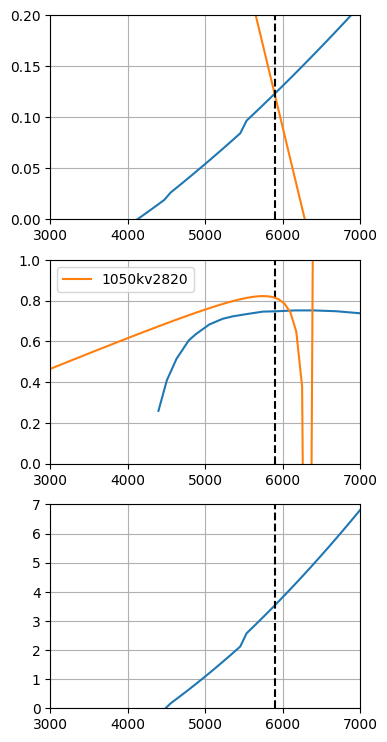

In [94]:
fig2, ax2 = plt.subplots(3,1, figsize=(4, 9))
ax2.ravel()

Vin = 7.2

ax2[0].plot(np.linspace(3000, 7000), GetTorque(np.linspace(3000, 7000), Va))
ax2[0].plot(np.linspace(3000, 7000), GetMTorque(np.linspace(3000, 7000), Vin))
ax2[0].vlines(5900, 0, 0.2, linestyle='--', color='black')
ax2[0].set_ylim(0, 0.2)
ax2[0].set_xlim(3000, 7000)
ax2[0].grid('Major')

ax2[1].plot(GetOmega(J6, Va), eta6)
ax2[1].vlines(5900, 0, 1, linestyle='--', color='black')
ax2[1].plot(np.linspace(3000, 6700), GetMEff(np.linspace(3000, 6700), Vin), label = '1050kv2820')
ax2[1].set_ylim(0, 1)
ax2[1].set_xlim(3000, 7000)
ax2[1].grid('Major')
ax2[1].legend()

ax2[2].plot(np.linspace(3000, 7000), GetThrust(np.linspace(3000, 7000), Va))
ax2[2].vlines(5900, 0, 7, linestyle='--', color='black')
ax2[2].set_ylim(0, 7)
ax2[2].set_xlim(3000, 7000)
ax2[2].grid('Major')
GetTotalPower(np.array([5900]), Vin, Va)